## Day14. Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

Instructions:

Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
Read the data into a Pandas dataframe.
Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
Create a logistic regression model to predict this variable from the cleaned data.
Evaluate the results.

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

········


### Q1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
### Q2. Read the data into a Pandas dataframe.

In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

In [3]:
query = '''with cte_rental as (
select
i.film_id,
date_format(convert(r.rental_date,date), '%m') as r_month,
date_format(convert(r.rental_date,date), '%Y') as r_year
from sakila.rental as r
right join sakila.inventory as i
on r.inventory_id=i.inventory_id
)
select f.film_id,cte.r_month, cte.r_year, f.rental_duration, f.rental_rate, f.length, f.rating, f.special_features, c.category_id,
case
when f.film_id in (select film_id from rental as r
join inventory as i
using(inventory_id)
join film as f
using(film_id)
where date_format(convert(r.rental_date,date), '%m') =2) then 1
else 0
end as rented_last_month
from cte_rental as cte
join sakila.film as f
on cte.film_id=f.film_id
join sakila.film_category as c
on f.film_id=c.film_id
;
'''

data = pd.read_sql_query(query,engine)
data.head()

,film_id,r_month,r_year,rental_duration,rental_rate,length,rating,special_features,category_id,rented_last_month
0,19,08,2005,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,1
1,19,08,2005,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,1
2,19,06,2005,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,1
3,19,07,2005,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,1
4,19,07,2005,6,0.99,113,PG,"Commentaries,Deleted Scenes,Behind the Scenes",1,1


### Q4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [36]:
data['rented_last_month']

0        1
1        1
2        1
3        1
4        1
        ..
16040    0
16041    0
16042    0
16043    0
16044    0
Name: rented_last_month, Length: 16045, dtype: int64

### Q3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.


In [4]:
data.shape

(16045, 10)

In [5]:
data.dtypes

film_id                int64
r_month               object
r_year                object
rental_duration        int64
rental_rate          float64
length                 int64
rating                object
special_features      object
category_id            int64
rented_last_month      int64
dtype: object

In [6]:
data['rating'].value_counts()

PG-13    3585
NC-17    3293
PG       3213
R        3181
G        2773
Name: rating, dtype: int64

In [7]:
def rating_ordi(x):
    if x== "G":
        x= 1
    elif x== "PG":
        x=2
    elif x== "PG-13":
        x=3
    elif x== "R":
        x=4
    else:
        x=5
    return x

In [8]:
data["rating"]=list(map(rating_ordi,data["rating"]))

In [9]:
data['special_features'].value_counts()

Trailers,Commentaries,Behind the Scenes                   1320
Trailers                                                  1151
Trailers,Commentaries                                     1140
Trailers,Behind the Scenes                                1137
Behind the Scenes                                         1114
Commentaries,Deleted Scenes,Behind the Scenes             1112
Commentaries                                              1101
Commentaries,Behind the Scenes                            1093
Trailers,Deleted Scenes                                   1065
Deleted Scenes,Behind the Scenes                          1050
Deleted Scenes                                            1037
Commentaries,Deleted Scenes                               1020
Trailers,Commentaries,Deleted Scenes,Behind the Scenes    1003
Trailers,Commentaries,Deleted Scenes                       922
Trailers,Deleted Scenes,Behind the Scenes                  780
Name: special_features, dtype: int64

In [10]:
#splitt features

In [11]:
def count_special_features(data_list):
    lx = lambda x: x.split(sep=',') #split by comas
    ly = lambda x: len(x) #lenght of the array
    #apply funtions
    data_list = data_list.apply(lx)
    data_list = data_list.apply(ly)
    return data_list

In [12]:
data['special_features'] = count_special_features(data['special_features'])

In [13]:
data.head()

,film_id,r_month,r_year,rental_duration,rental_rate,length,rating,special_features,category_id,rented_last_month
0,19,08,2005,6,0.99,113,2,3,1,1
1,19,08,2005,6,0.99,113,2,3,1,1
2,19,06,2005,6,0.99,113,2,3,1,1
3,19,07,2005,6,0.99,113,2,3,1,1
4,19,07,2005,6,0.99,113,2,3,1,1


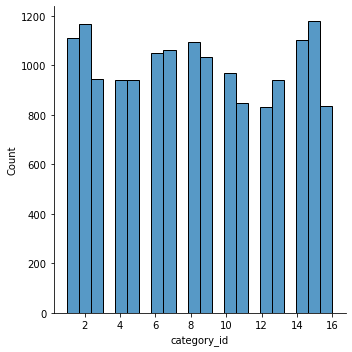

In [14]:
sns.displot(data['category_id'])
plt.show()

In [16]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [17]:
data.dtypes

film_id                int64
r_month               object
r_year                object
rental_duration        int64
rental_rate          float64
length                 int64
rating                 int64
special_features       int64
category_id            int64
rented_last_month      int64
dtype: object

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

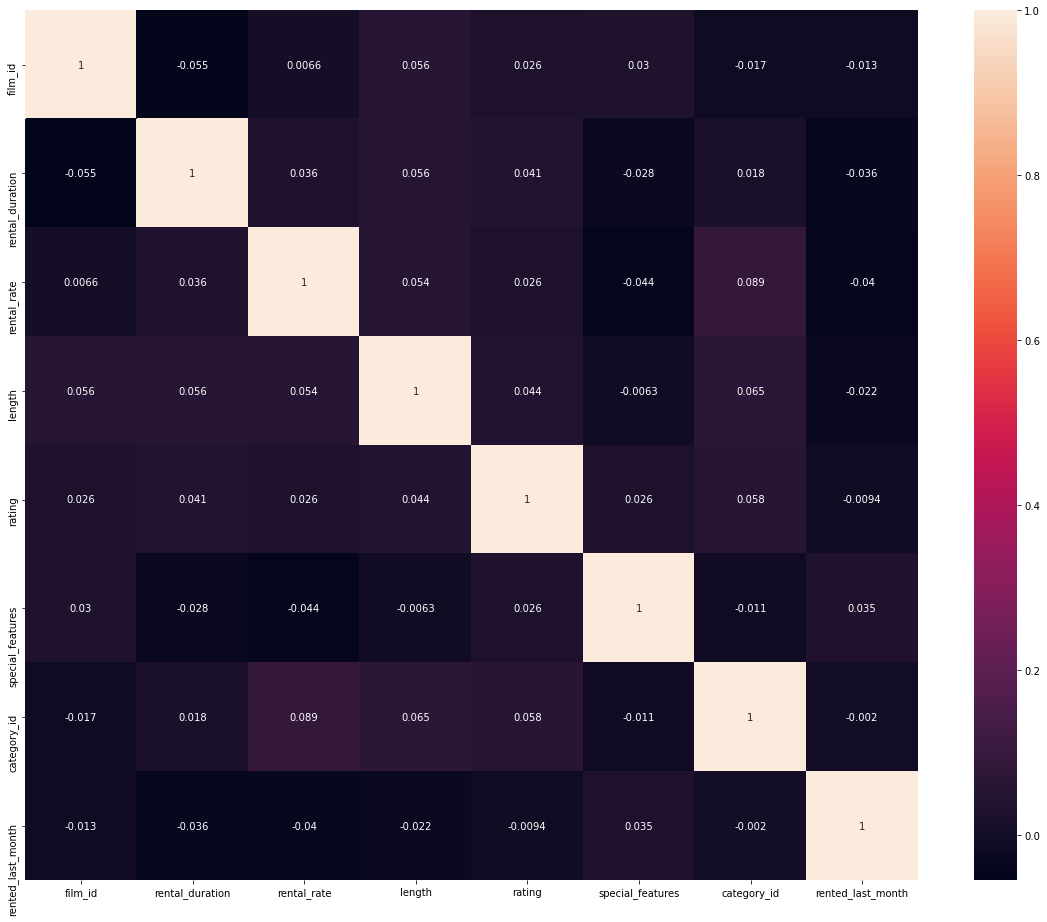

In [19]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(20, 16))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [20]:
data.isna().sum()

film_id              0
r_month              1
r_year               1
rental_duration      0
rental_rate          0
length               0
rating               0
special_features     0
category_id          0
rented_last_month    0
dtype: int64

In [21]:
data1 = data[data['r_month'].isna() == False]

In [22]:
data1 = data[data['r_year'].isna() == False]

In [23]:
data1.isna().sum()

film_id              0
r_month              0
r_year               0
rental_duration      0
rental_rate          0
length               0
rating               0
special_features     0
category_id          0
rented_last_month    0
dtype: int64

In [24]:
def scaling(df,target,scaler):
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import Normalizer
    #x-y-split
    Y=df[target]
    X=df.drop([target],axis=1)
    
    #chosing scaler
    #StandardScaler
    if scaler=="StandardScaler":
        scaler_x = StandardScaler().fit(X)
        X_scaled = pd.DataFrame(scaler_x.transform(X),columns=X.columns)
        
        return X_scaled,Y
    #MinMaxScaler()
    elif scaler=="MinMax":
        X_scaled = MinMaxScaler().fit_transform(X.values)
        X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
        
        return X_scaled,Y
    #Normalizer
    elif scaler=="Normalizer":
        transformer = Normalizer().fit(X)
        X_scaled = pd.DataFrame(transformer.transform(X),columns=X.columns)
        
        return X_scaled,Y

In [25]:
X_scaled,Y=scaling(data1,"rented_last_month","MinMax")

film_id


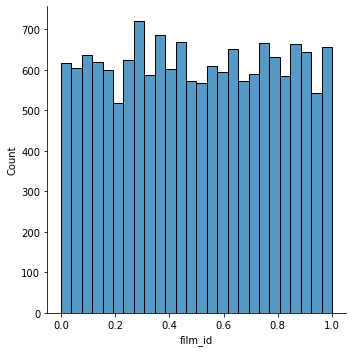

r_month


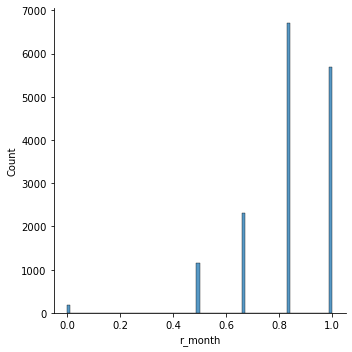

r_year


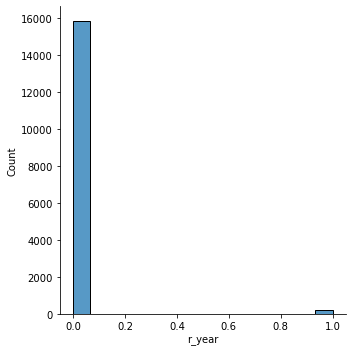

rental_duration


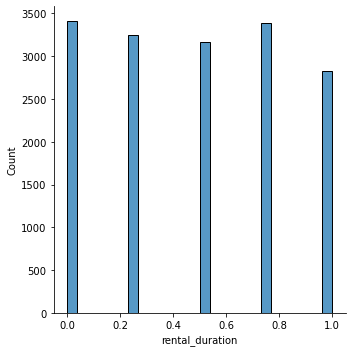

rental_rate


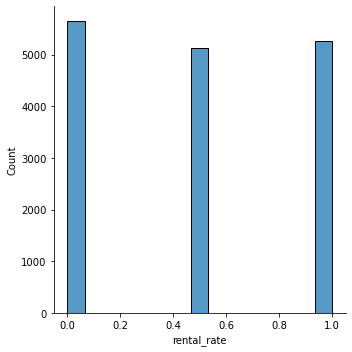

length


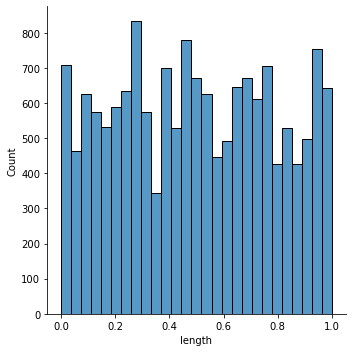

rating


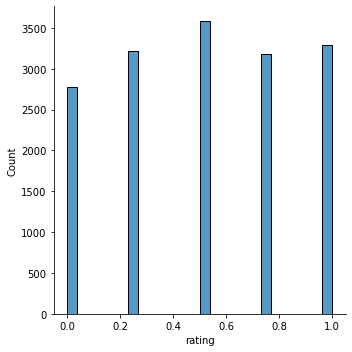

special_features


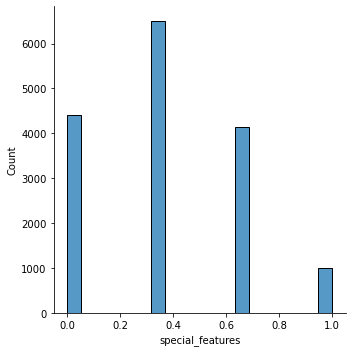

category_id


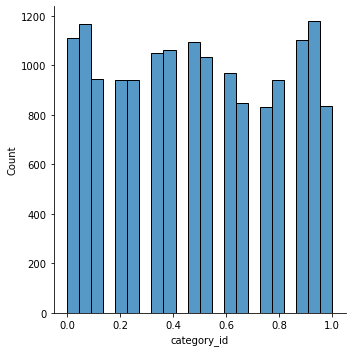

In [26]:
for col in list(X_scaled.columns):
    print(col)
    sns.displot(X_scaled[col])
    plt.show()

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=100)

### Q5. Create a logistic regression model to predict this variable from the cleaned data.
### Q6. Evaluate the results.

In [28]:
#Train the model

In [29]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [30]:
print("The accuracy of the model in the TEST set is: ", round(classification.score(X_test, y_test),2))

The accuracy of the model in the TEST set is:  0.81


In [31]:
predictions = classification.predict(X_test)
classification.score(X_test, y_test)

0.8144993768176153

In [32]:
y_test.value_counts() #huge imbalance

0    3866
1     948
Name: rented_last_month, dtype: int64

In [33]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, predictions)


array([[3866,    0],
       [ 893,   55]], dtype=int64)

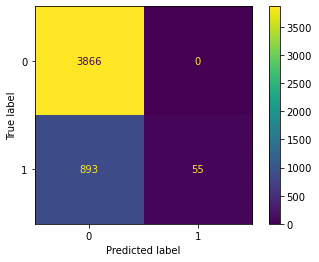

In [34]:
plot_confusion_matrix(classification, X_test, y_test)